In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from datetime import datetime, date
import json
import geopandas as gpd
import requests
import matplotlib.pyplot as plt

In [2]:
# Select modeling domain
domain = 'BEAU'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# SM forcing files 
SMdatapath = datapath+'SMinputs/'+domain+'/'
# dem tif
demtif = SMdatapath+domain+'_dem.tif'

# historical ET data - na
path_hist = '/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/'
# future ET data - na
path_fut = '/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/'
# historical ET data - domain
path_hist_out = datapath+'climate_na_et/Normal_1991_2020_monthly/'+domain+'/'
# future ET data - domain
path_fut_out = datapath+'climate_na_et/ensemble_8GCMs_ssp585_2071_2100/'+domain+'/'

## historic et data

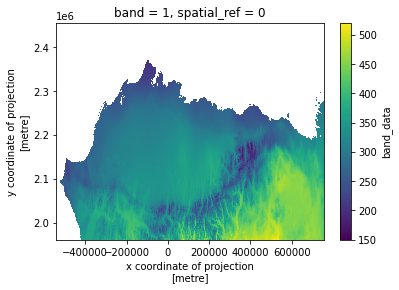

In [3]:
#historic annual data
refdata = xr.open_dataarray(demtif)
histpathyr = path_hist+'Normal_1991_2020_Eref_annual.tif'
datayr = xr.open_dataarray(histpathyr)
repr_match = datayr.rio.reproject_match(refdata)
repr_match.plot()

In [4]:
# months of the year
mos = [12,1,2,3,4,5,6,7,8,9,10,11,12,1]
# month labels
molab = [0.5,1,2,3,4,5,6,7,8,9,10,11,12,12.5]

# load xarray datasets
# reference data - domain dem
refdata = xr.open_dataarray(demtif)

# create empty array to store monthly files 
moet = np.empty([14,len(refdata.y),len(refdata.x)])
for i in range(len(mos)):
    # load climate na data at full extent
    path = path_hist+'Normal_1991_2020_Eref'+'{:02}'.format(mos[i])+'.tif'
    print(path)
    tempetdata = xr.open_dataarray(path)
    # clip to domain extent and reproject to match domain
    repr_match = tempetdata.rio.reproject_match(refdata)
    # set negative et values to 0
    repr_match_no0 = np.squeeze(repr_match.values)
    repr_match_no0[repr_match_no0<0] = 0
    #add to empty data array
    moet[i,:,:]=repr_match_no0

/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref12.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref01.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref02.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref03.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref04.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref05.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref06.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref07.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref08.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref09.tif
/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/Normal_1991_2020_Eref10.tif
/nfs/attic/dfh/data/climate_na_et/Normal_19

In [5]:
# build xarray data array to save out
etmoclip = xr.DataArray(
    moet,
    coords={
        "month":molab,
        "y": refdata.y.values,
        "x": refdata.x.values,
    },
    dims=["month","y", "x"],
)
# convert to dataset
ds=etmoclip.to_dataset(name = 'et')
ds

<xarray.Dataset>
Dimensions:  (month: 14, y: 496, x: 1298)
Coordinates:
  * month    (month) float64 0.5 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0 12.5
  * y        (y) float64 2.456e+06 2.454e+06 2.454e+06 ... 1.962e+06 1.96e+06
  * x        (x) float64 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    et       (month, y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

In [6]:
# save as netcdf
path = path_hist_out+'historic_monthly_et.nc'
ds.to_netcdf(path)

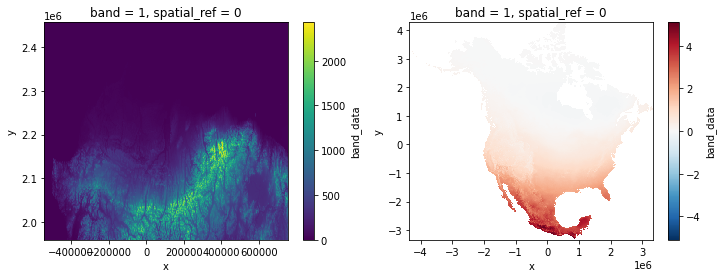

In [7]:
# plot domain dem and climate na full extent
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
refdata.plot(ax=axes[0])
tempetdata.plot(ax=axes[1])
plt.draw()

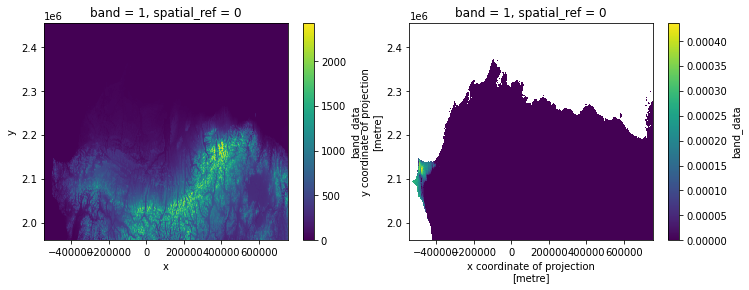

In [8]:
# plot domain dem and climate na clipped extent
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
refdata.plot(ax=axes[0])
repr_match.plot(ax=axes[1])
plt.draw()

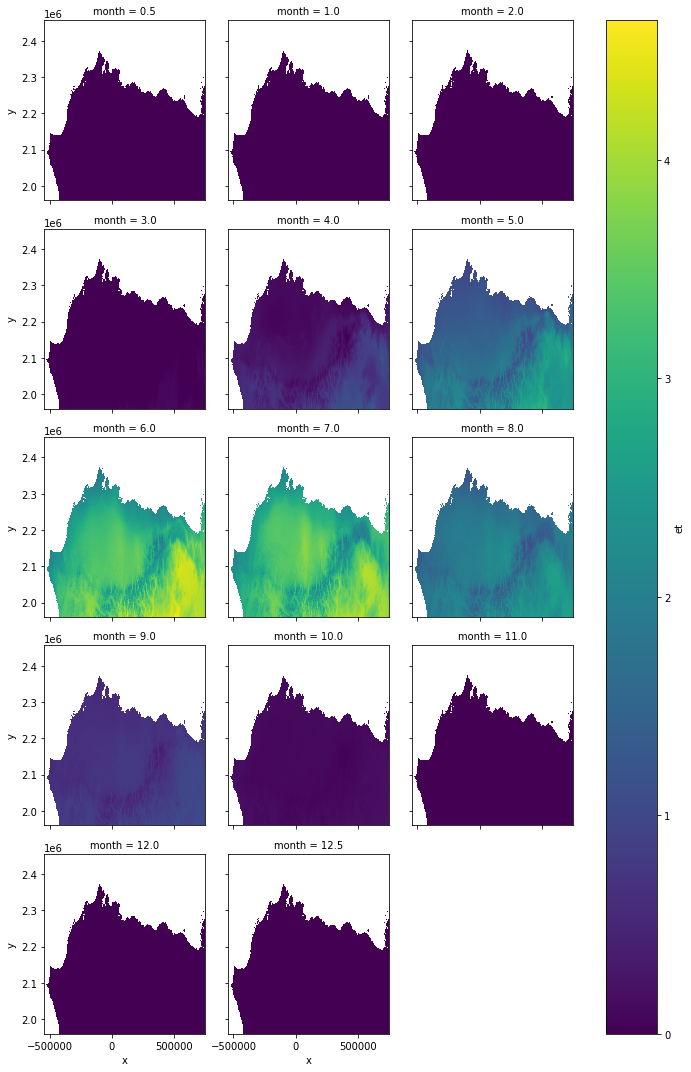

In [11]:
molist = [1,2,3,4,5,6,7,8,9,10,11,12]
histpath = path_hist_out+'historic_monthly_et.nc'
datah = xr.open_dataset(histpath)
et_simple = datah.et.sel().plot(x="x", y="y", col="month", col_wrap=3)

In [10]:
datah.et.min(dim=['x','y'])

<xarray.DataArray 'et' (month: 12)>
array([0.        , 0.        , 0.        , 0.        , 0.7737326 ,
       1.65376544, 1.59017015, 0.89046752, 0.27515513, 0.01156123,
       0.        , 0.        ])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [11]:
datah.et.mean(dim=['x','y'])

<xarray.DataArray 'et' (month: 12)>
array([2.55492360e-06, 9.70118317e-05, 6.62222771e-03, 4.03612545e-01,
       1.72206331e+00, 3.20646995e+00, 3.15026196e+00, 1.91993632e+00,
       7.26282975e-01, 1.17264674e-01, 6.01582753e-04, 4.81101582e-07])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## future et data

In [12]:
# months of the year
mos = [12,1,2,3,4,5,6,7,8,9,10,11,12,1]
# month labels
molab = [0.5,1,2,3,4,5,6,7,8,9,10,11,12,12.5]

# load xarray datasets
# reference data - domain dem
refdata = xr.open_dataarray(demtif)

# create empty array to store monthly files 
moet = np.empty([14,len(refdata.y),len(refdata.x)])
for i in range(len(mos)):
    # load climate na data at full extent
    path = path_fut+'ensemble_8GCMs_ssp585_2071_2100_Eref'+'{:02}'.format(mos[i])+'.tif'
    print(path)
    tempetdata = xr.open_dataarray(path)
    # clip to domain extent and reproject to match domain
    repr_match = tempetdata.rio.reproject_match(refdata)
    # set negative et values to 0
    repr_match_no0 = np.squeeze(repr_match.values)
    repr_match_no0[repr_match_no0<0] = 0
    #add to empty data array
    moet[i,:,:]=repr_match_no0

/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref12.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref01.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref02.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref03.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref04.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref05.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref06.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref07.tif
/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/ensemble_8GCMs_ssp585_2071_2100_Eref08.tif
/nfs/attic/dfh/data

In [13]:
# build xarray data array to save out
etmoclip = xr.DataArray(
    moet,
    coords={
        "month":molab,
        "y": refdata.y.values,
        "x": refdata.x.values,
    },
    dims=["month","y", "x"],
)
# convert to dataset
ds=etmoclip.to_dataset(name = 'et')
ds

<xarray.Dataset>
Dimensions:  (month: 14, y: 496, x: 1298)
Coordinates:
  * month    (month) float64 0.5 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0 12.5
  * y        (y) float64 2.456e+06 2.454e+06 2.454e+06 ... 1.962e+06 1.96e+06
  * x        (x) float64 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    et       (month, y, x) float64 nan nan nan nan ... 0.003489 0.0032 0.003086

In [14]:
# save as netcdf
path = path_fut_out+'future_monthly_et.nc'
ds.to_netcdf(path)

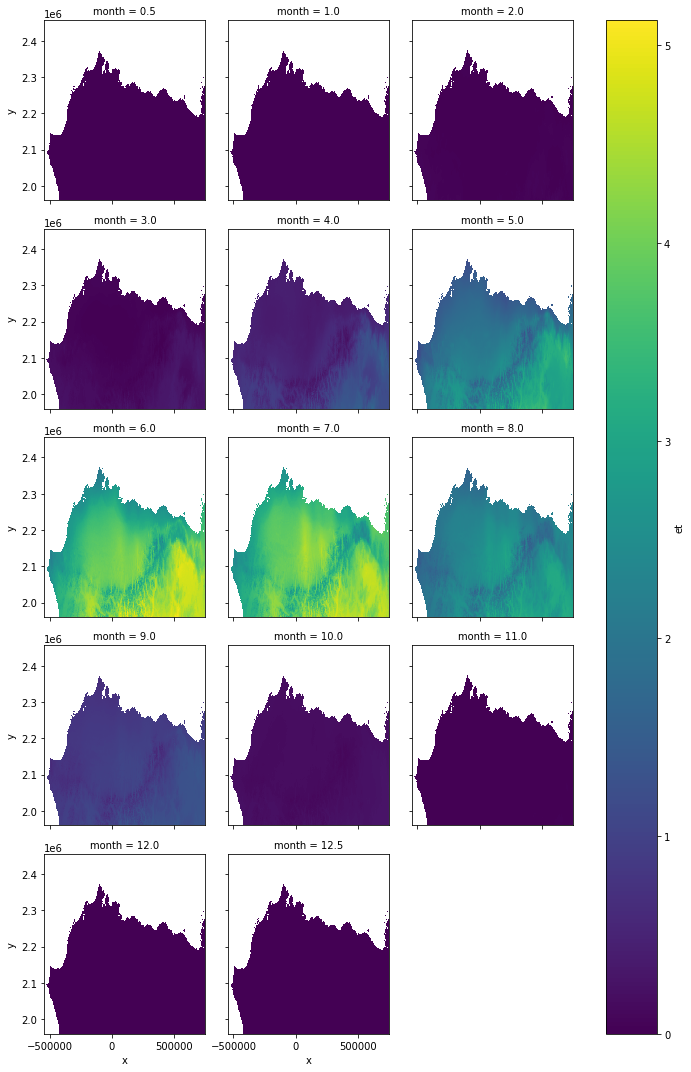

In [15]:
futpath = path_fut_out+'future_monthly_et.nc'
dataf = xr.open_dataset(futpath)
et_simple = dataf.et.plot(x="x", y="y", col="month", col_wrap=3)

In [16]:
dataf.et.min(dim=['x','y'])

<xarray.DataArray 'et' (month: 14)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.52590036e-01, 1.06043112e+00, 2.01284266e+00, 2.08660483e+00,
       1.30930948e+00, 4.65870053e-01, 7.20694438e-02, 9.10080154e-04,
       0.00000000e+00, 0.00000000e+00])
Coordinates:
  * month    (month) float64 0.5 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0 12.5